In [17]:
"""
from google.colab import drive
drive.mount('/content/gdrive/')

#!pip install -q condacolab
#import condacolab
#condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision
"""

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive/')\n\n#!pip install -q condacolab\n#import condacolab\n#condacolab.install()\n\n%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests\n!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert\n!pip install papermill[all]\n!pip install torchvision\n"

In [1]:

import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__

from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.seqsDataLoader_fix import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

from src.models.encoder_decoder import get_encoder, get_decoder
from src.seqsDataLoader_fix import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

from src.models.DeepSequence import DeepSequence
from src.models.C_LA_VITAE import C_LA_VITAE


/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode
Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2
    if space=='log':
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]
    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16

    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=10, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction

    # Paths to use
    paths = parser.add_argument_group('Paths')
  
    paths.add_argument('--path_orig', type=str, default="../data/set_preprint/WWseeds_tunningPGM_set_60seqs.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_test', type=str, default="../data/set_preprint/WWseeds_tunningPGM_set_60seqs_test.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/set_preprint/WWseeds_aligned_for_pretrained.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta

    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case')
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report')
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    
    gpsetup.add_argument('--Task', type=int, default = 22, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(22, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-6,1e-5], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="cpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=1750, help='number of tesselation cells') #6 80, the increasing of tess improve the performance when there are more samples to train the density estimator
    cpab.add_argument('--channels', type=int, default=1750, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps')

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=60, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')


    # Parse and return
    args = parser.parse_args()
    return args

In [3]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')


path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_test = std.parserinfo('path_test')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')


gp_params = std.get_config_vals(['noise_constraint',
                                 'Task',
                                 'interpolation_type',
                                 'Option',
                                 'Lengthscale',
                                 'Initialization'])

alphabets = ['?','-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 
             'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] 


logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_preprint_C_LA_VITAE_20June2025.pth'



None


In [4]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader


c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, 
                                alphabet = alphabets, 
                                enable_variable_length=True, 
                                device=device)

dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, 
                                        alphabet = alphabets, 
                                        enable_variable_length=True, 
                                        device=device)

dataset_test = seqsDatasetLoader(pathBLAT_data = path_test, 
                                 alphabet = alphabets, 
                                 enable_variable_length=True, 
                                 device=device)

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

trainloader, testloader = Sequence_Data_Loader(dataset_msa, 
                                               dataset_test = None, batch_size = batches)

trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, 
                                                                     dataset_test = None, 
                                                                     batch_size = 112)

seq_size = ( [*dataset_msa.prot_space.shape][1:])

Ok
Ok
Ok
Loading data


/home/kvr226/Explicit_Disentanglement_Molecules/src/seqsDataLoader_fix.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


In [5]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, 
                       args.latent_dim, 
                       alphabets, device = device, 
                       outputnonlin = torch.nn.LeakyReLU(0.01))

optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr*0.1)

loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, 
                                        map_location=casted_device) )
    print ("Loaded")
    #for param in deepseq.parameters():
    #    param.requires_grad = False
else:
    deepseq.training_representation(trainloader_pretrainer, 
                                    optimizer_deepseq, 
                                    2000, 
                                    warmup=1, 
                                    logdir = logdir, 
                                    out_modelname = outmodel_name)

deepseq(dataset_msa.prot_space)
#plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)


Loading Deformation Model...
Loaded


(tensor([[[-0.8701,  2.8642,  5.4597,  ...,  5.1990, -0.8929,  2.6448],
          [-0.2283, -0.3404,  6.5416,  ...,  5.4326, -0.2536, -0.2414],
          [-0.2543, -0.2632,  6.5119,  ...,  5.3502, -0.7896,  4.9603],
          ...,
          [-0.0642, -0.0859,  5.7904,  ...,  8.1465, -0.0639, -0.0638],
          [-0.2363, -0.5050,  5.2632,  ...,  6.3148, -0.2737,  4.1494],
          [-0.0331,  8.0477,  8.7447,  ..., -0.0441, -0.0431, -0.0308]],
 
         [[-0.9080,  2.8877,  5.6250,  ...,  5.4223, -0.9393,  2.8988],
          [-0.2417, -0.3605,  6.8206,  ...,  5.6887, -0.2688, -0.2510],
          [-0.2671, -0.2786,  6.8482,  ...,  5.7412, -0.8324,  5.0672],
          ...,
          [-0.0660, -0.0909,  5.9902,  ...,  8.7206, -0.0676, -0.0648],
          [-0.2488, -0.5327,  5.4649,  ...,  6.8509, -0.2851,  4.3698],
          [-0.0355,  8.5204,  9.0125,  ..., -0.0472, -0.0463, -0.0316]],
 
         [[-0.9704,  3.0107,  6.0137,  ...,  5.7349, -1.0022,  3.0111],
          [-0.2583, -0.3837,

In [7]:
import time
import copy


def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()

def fit_VITAE_with_pretrained_DeepSeq(trainloader, 
                                      optimizer, 
                                      model, 
                                      DS, 
                                      n_epochs=10, 
                                      warmup=1, 
                                      logdir='',
                                      testloader=None, 
                                      eq_samples=1,
                                      iw_samples=1, 
                                      beta=1.0, 
                                      eval_epoch=10000, 
                                      **kargs):
        """ Fits the supplied model to a training set
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''

        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))

        model.train()

        loss_function = LossFunctionsAlternatives()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs),
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0

            for i, data in enumerate(trainloader):
                # Zero gradient
                #import ipdb; ipdb.set_trace()
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)

                # Calculat loss                
                loss = model.get_elbo(data, out, beta=0.5e-3).mean()

                # Backpropegate and optimize
                loss.backward()

                ### UPDATE MODEL PARAMETERS
                optimizer.step()

                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })

                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()

        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [8]:

batch_loss_dict = {}

logdir_density = 'pretrained_densities' 
outmodel_name_density = 'trained_density_WW_22_preprint_20June2025_batchsize_10.pth'
pretrained_density = logdir_density + "/" + outmodel_name_density

import os


# Construct model
# I do not add the pretrained deepsequence module to avoid
# the backpropagation of such module during the optimization
model = C_LA_VITAE(
                    input_shape = seq_size, #img_size,
                    config = std,
                    latent_dim = args.latent_dim,
                    encoder = get_encoder( args.ed_type.split(",")[0] ),
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    posterior_variance = True,
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-575,575])


# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)#, weight_decay=1e-19)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'


if os.path.isfile(pretrained_density):
    print ("Loading Density Model...")
    model.load_state_dict( torch.load(pretrained_density, map_location=casted_device) )
    print ("Loaded")
else:
    fit_VITAE_with_pretrained_DeepSeq(trainloader, 
                                      opt, 
                                      model, 
                                      deepseq, 
                                      n_epochs=600, 
                                      warmup=1, 
                                      logdir='',
                                      testloader=None, 
                                      eq_samples=1, 
                                      iw_samples=1, beta=1.0, eval_epoch=10) # initi
    
    torch.save(model.state_dict(), pretrained_density)

No CUDA runtime is found, using CUDA_HOME='/home/kvr226/miniconda3/envs/PGM_latent_alignment'
> /home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/transformer.py(27)<module>()
     26 import ipdb; ipdb.set_trace()
---> 27 _dir = get_dir(__file__)
     28 _verbose = False # TODO: set this flag in the main class, maybe


Program interrupted. (Use 'cont' to resume).
> /home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/file_baton.py(41)wait()
     40         '''
---> 41         while os.path.exists(self.lock_file_path):
     42             time.sleep(self.wait_seconds)

Loading Density Model...
Loaded


In [9]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker



def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs


def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt

    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize) #; fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet]
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)

        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)

/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


Done
tensor([[[ 1.6535e-01,  0.0000e+00,  0.0000e+00,  ...,  1.0668e-12,
          -8.7923e-04,  1.4750e-04],
         [ 2.0558e-02,  0.0000e+00,  0.0000e+00,  ..., -8.3409e-12,
           6.1112e-03, -1.0199e-03],
         [ 4.3202e-02,  0.0000e+00,  0.0000e+00,  ...,  4.5832e-11,
          -4.0334e-02,  6.7382e-03],
         ...,
         [ 6.4075e-04,  0.0000e+00,  0.0000e+00,  ...,  1.0988e-06,
          -9.1230e-03,  1.5489e-12],
         [ 1.8651e-03,  0.0000e+00,  0.0000e+00,  ...,  2.0555e-08,
          -2.9464e-03,  4.0458e-15],
         [-2.5258e-02,  0.0000e+00,  0.0000e+00,  ...,  1.4809e-10,
           9.2917e-04,  6.4714e-18]],

        [[-3.1810e-02,  0.0000e+00,  9.7617e-01,  ...,  0.0000e+00,
          -9.5982e-05,  0.0000e+00],
         [ 2.2207e-02,  0.0000e+00, -4.8540e-02,  ...,  0.0000e+00,
           9.5273e-04,  0.0000e+00],
         [ 1.3131e-04,  0.0000e+00, -5.5726e-04,  ...,  0.0000e+00,
           8.5792e-04,  0.0000e+00],
         ...,
         [ 5.3135e-0

"\nprint(f.renderText('INPUT'))\nplot_logos_probs(dataset_msa.prot_space.detach().cpu(), alphabets)\n\nprint(f.renderText('RECONSTRUCTION'))\nplot_logos_probs(recon_data_train[0].detach().cpu(), alphabets)\n\nprint(f.renderText('ALIGNMENT'))\nplot_logos_probs(recon_data_train[5].detach().cpu(), alphabets)\n"

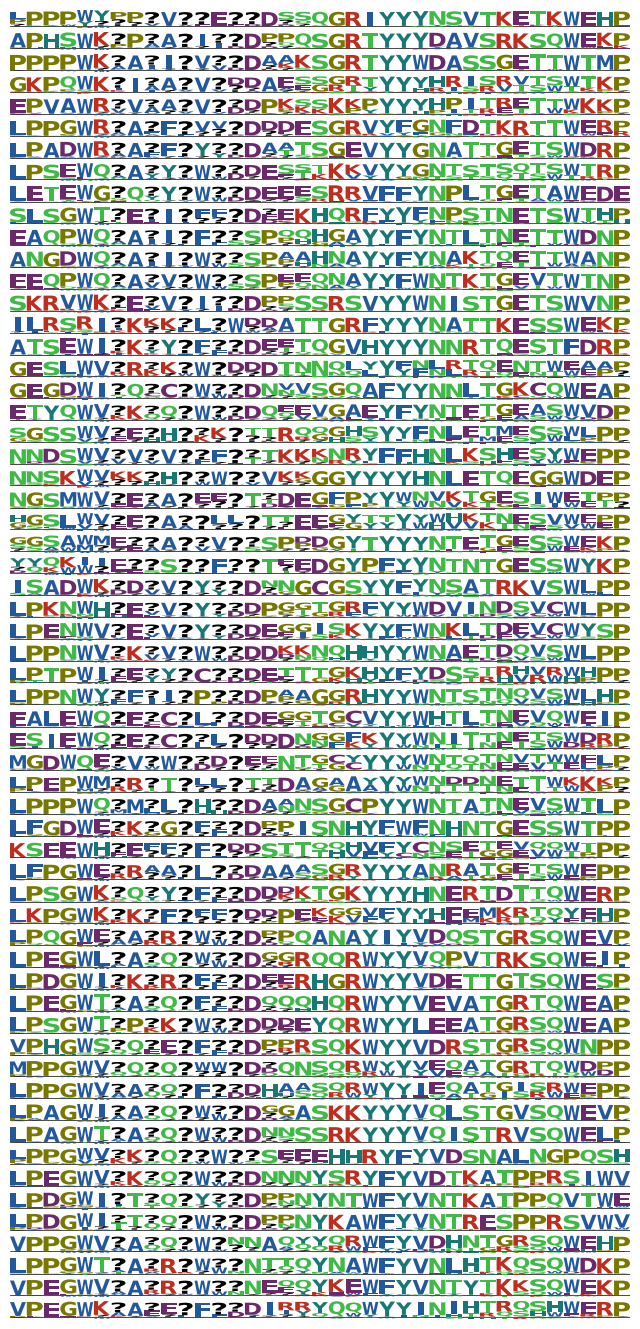

In [10]:
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)

test_set_alignment = model(dataset_test.prot_space, deepseq)



print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]



plot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(8,17), show_axis=False)




"""
print(f.renderText('INPUT'))
plot_logos_probs(dataset_msa.prot_space.detach().cpu(), alphabets)

print(f.renderText('RECONSTRUCTION'))
plot_logos_probs(recon_data_train[0].detach().cpu(), alphabets)

print(f.renderText('ALIGNMENT'))
plot_logos_probs(recon_data_train[5].detach().cpu(), alphabets)
"""


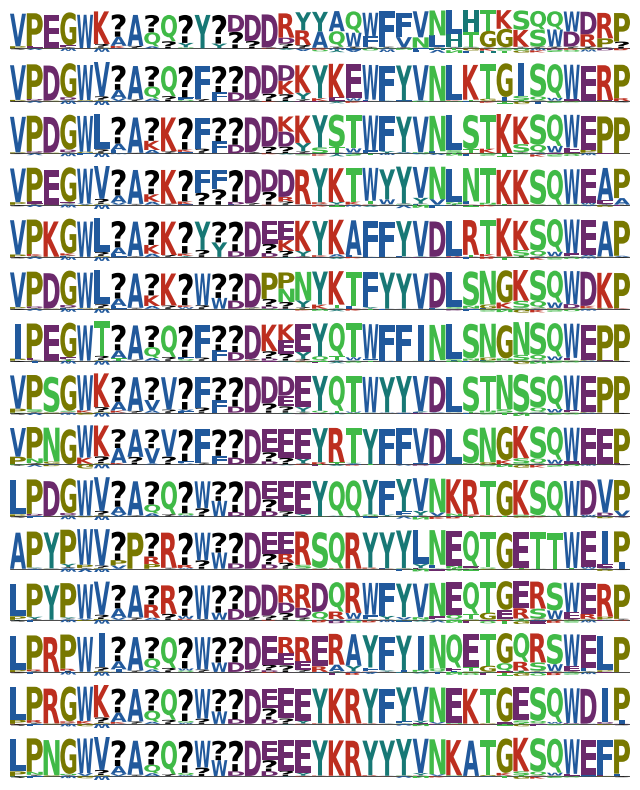

In [12]:
plot_msa_from_preds(test_set_alignment[5].detach().cpu(), alphabets, figsize=(8,10), show_axis=False)


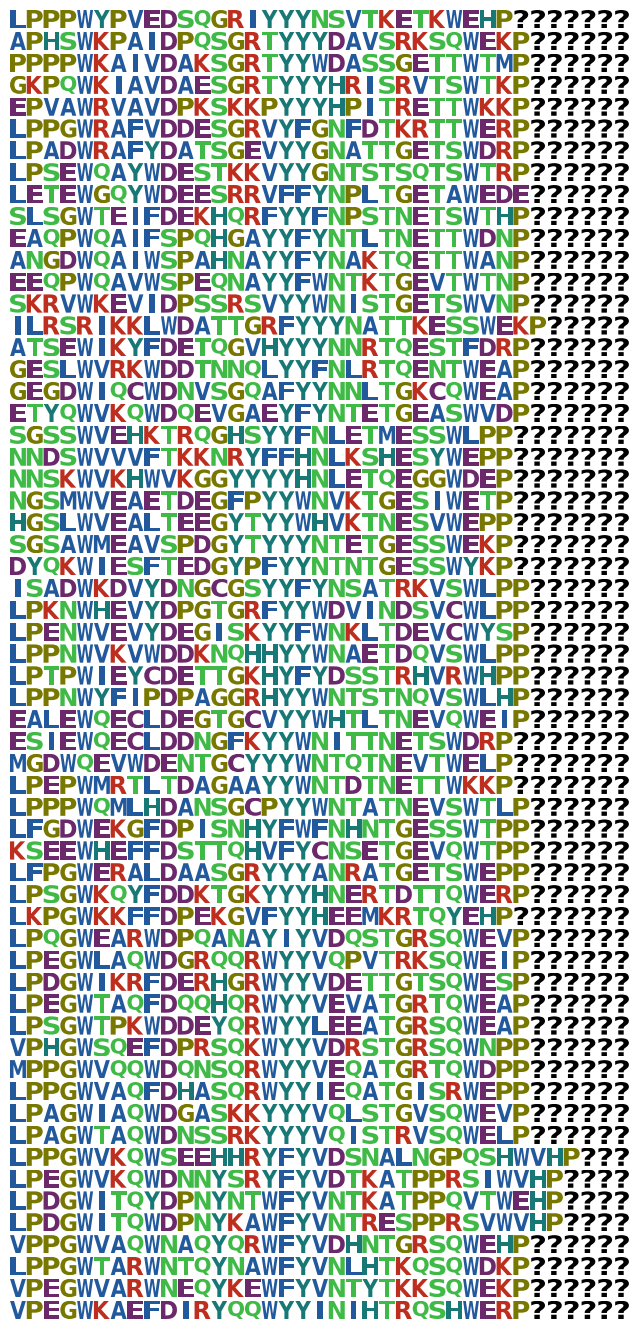

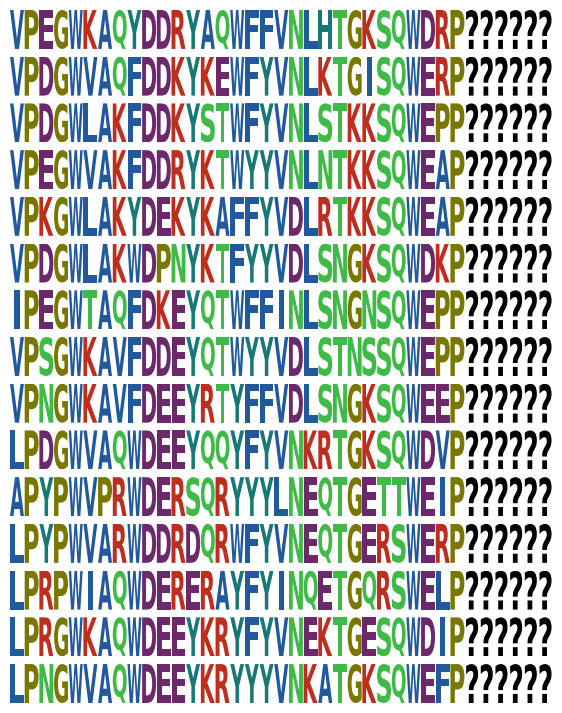

In [29]:
plot_msa_from_preds(trainloader.dataset.prot_space.detach().cpu(), alphabets, figsize=(8,17), show_axis=False)
plot_msa_from_preds(dataset_test.prot_space.detach().cpu(), alphabets, figsize=(7,9), show_axis=False)



IndexError: index 5 is out of bounds for axis 1 with size 5

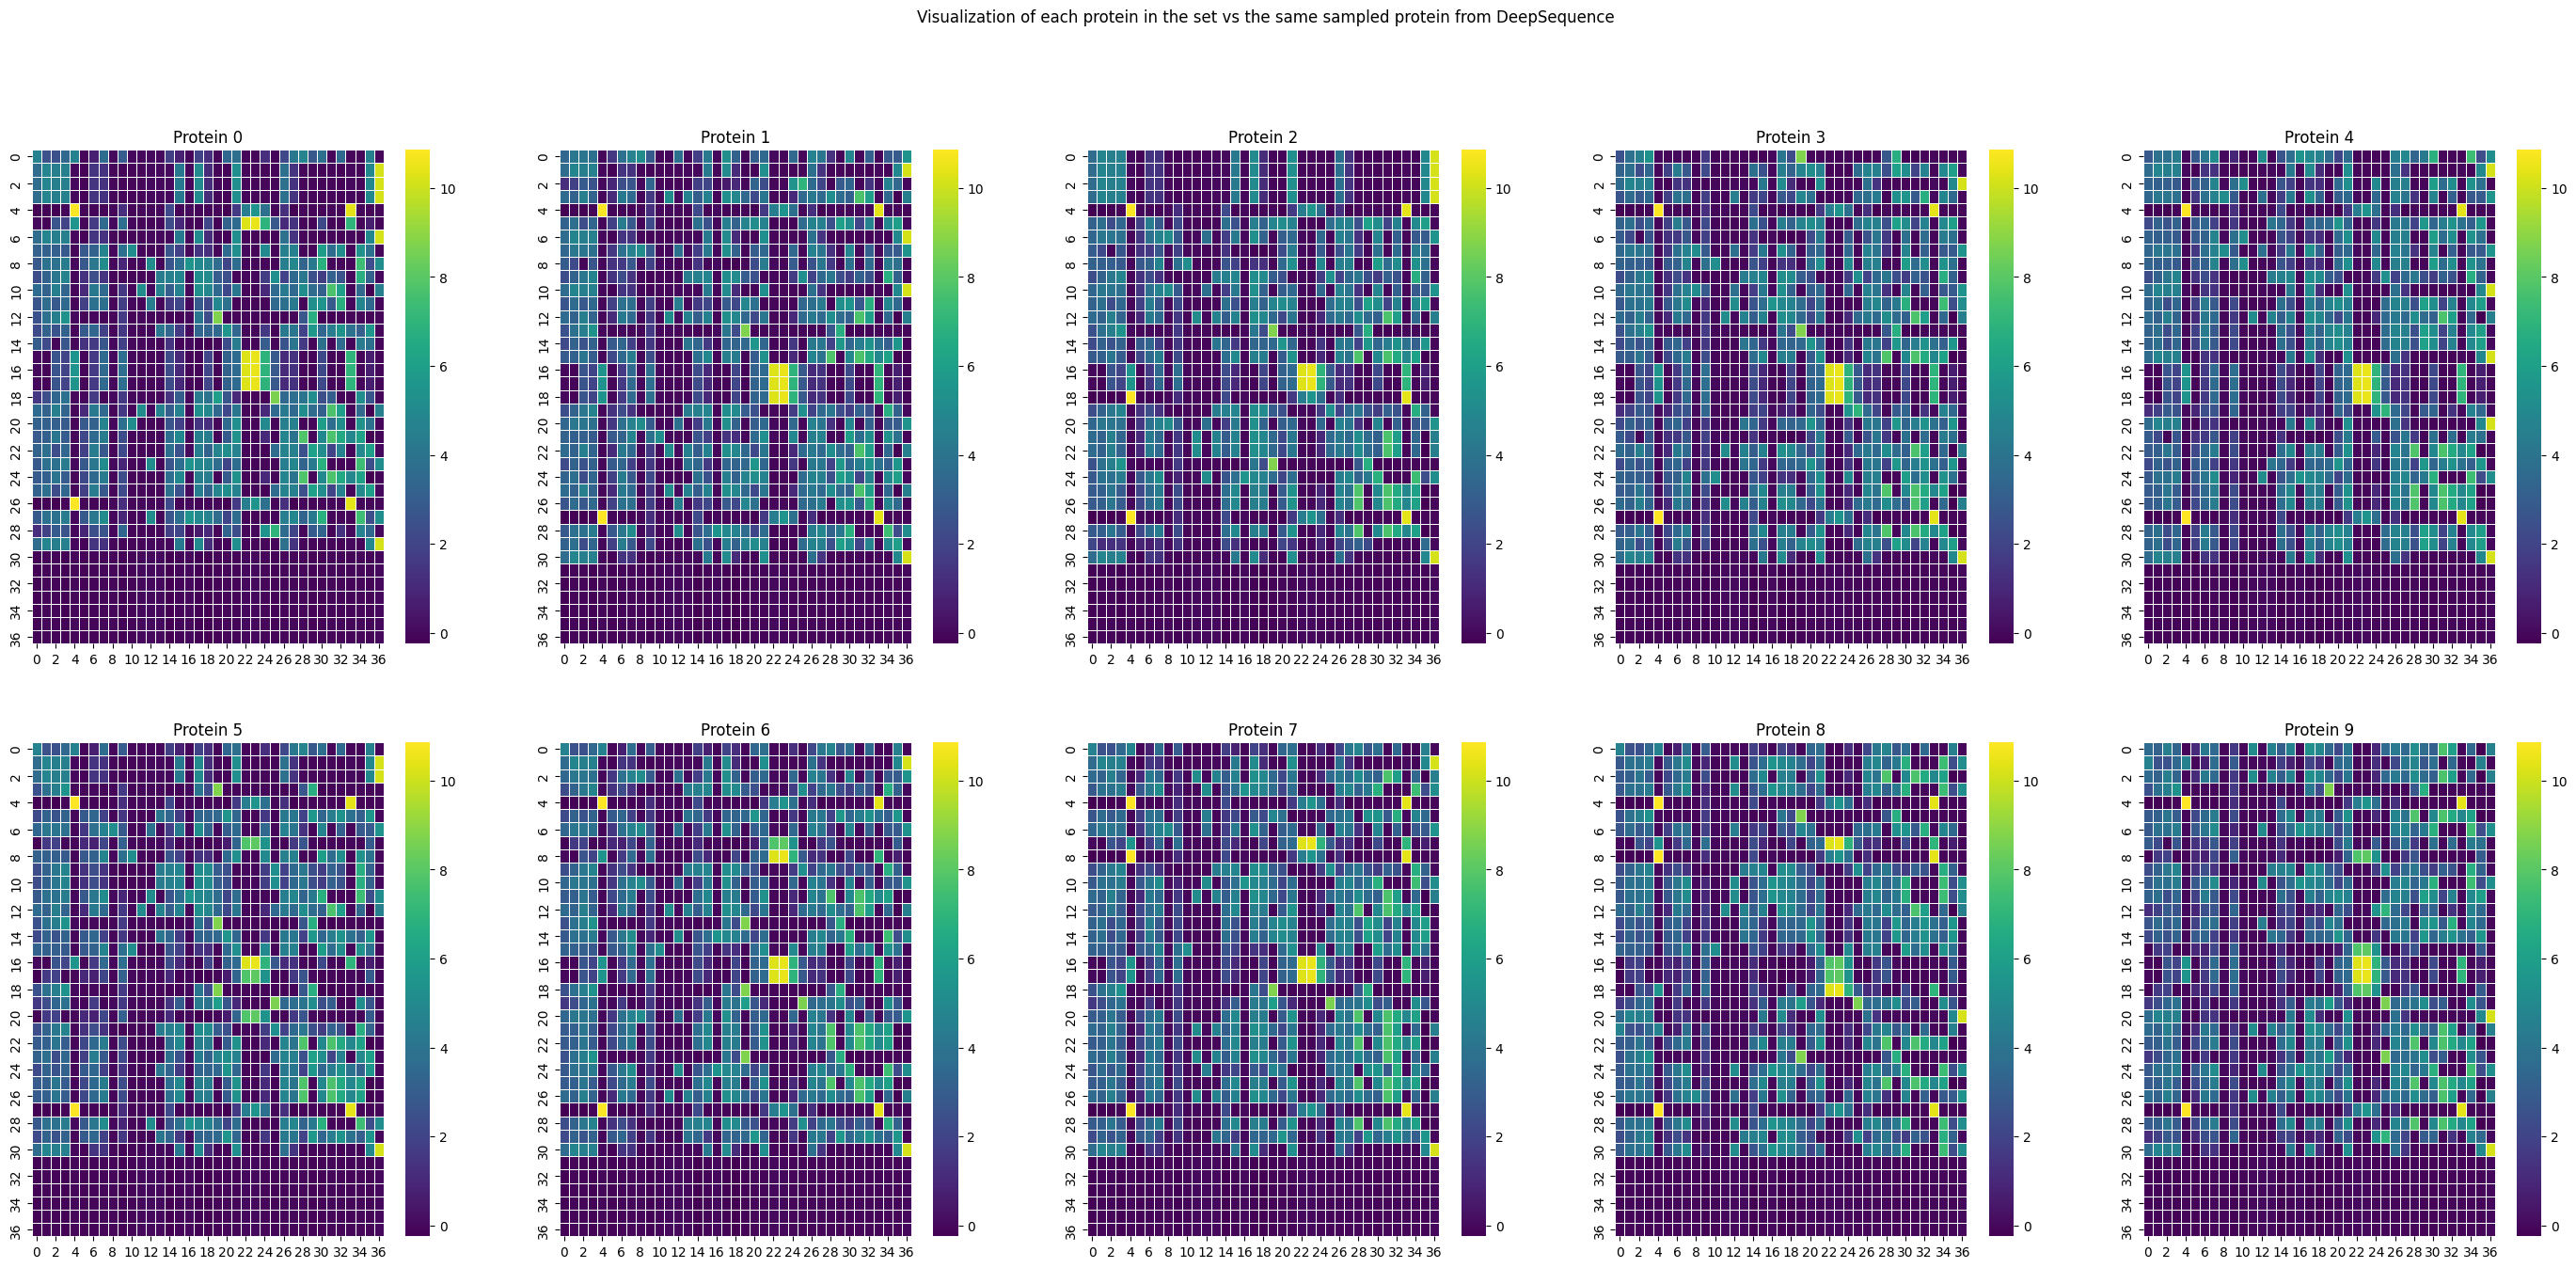

In [30]:
import seaborn as sns
import matplotlib.pylab as plt

def MonteCarlo_sampleDS(DS, iters):
    set_of_samples = [ DS.sample(1)[0] for i in range(0,iters)]
    MC_sample = torch.mean(torch.stack(set_of_samples), dim=0)
    return MC_sample

def energy_info_DSsampling_vs_Raw(DS, batch_seqs):

    #import ipdb; ipdb.set_trace()
    batch_size = batch_seqs.shape
    raw_seqs = batch_seqs; DS.eval()
    sampled_seqs = MonteCarlo_sampleDS(DS,100)

    sampled_seqs = sampled_seqs.permute(0,2,1)

    # One Sampled Protein from Deep Sequence vs all 10 proteins
    fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
    fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')
    list_of_attentions = []
    for cont, prot in enumerate(raw_seqs):
        # One Sampled Protein from Deep Sequence vs all 10 proteins
        ii,jj = ((1,cont-5), (0,cont))[cont < 5]
        seq = torch.matmul(prot,sampled_seqs[0])
        list_of_attentions.append(seq.detach().cpu())
        axes1vs10[ii,jj].set_title('Protein ' + str(cont))
        sns.heatmap(seq.detach().cpu().numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])

    plt.show()
    return list_of_attentions


import torch.nn.functional as F

def get_diagonal_attention(Matrix, comp, min_r, max_r, list_attention = []):
    # Works assuming that we are dealing with square matrixes
    if comp <= max_r and comp >= min_r:
        list_attention.append( torch.cat( (torch.tensor([0.0]*abs(comp)) , torch.diagonal(Matrix, comp)) ) )
        get_diagonal_attention(Matrix, comp-1, min_r, max_r, list_attention)

def get_batch_diagonal_attention(Matrix, comp, min_r, max_r):
    list_batch = []
    list_attention = []
    for m in Matrix:
        get_diagonal_attention(m, comp, min_r, max_r, list_attention )
        list_batch.append( torch.stack(list_attention) )
        list_attention.clear()

    batch_diag_attention = torch.stack(list_batch)
    return batch_diag_attention


attentions = energy_info_DSsampling_vs_Raw( deepseq, dataset_msa.prot_space.detach())



In [ ]:
att = get_batch_diagonal_attention(attentions,10,-10, 10)

figatt, axesatt = plt.subplots(2, 5, figsize=(35,15))
figatt.suptitle('Visualization attention diagonals')

for cont, at in enumerate(att):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axesatt[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(at.numpy(), linewidth=0.5, cmap='viridis', ax=axesatt[ii,jj])

plt.show()

'''
Matrix = torch.tensor([[1,2,3,4,5],[33,44,55,66,77],[333,444,555,666,777],[3333,4444,5555,6666,7777],[33333,44444,55555,66666,77777]])
list_attention = []
get_diagonal_attention(Matrix, 2, -2, 2, list_attention)

Matrix2 = Matrix.repeat(2,1,1)
get_batch_diagonal_attention(Matrix2, 2, -2, 2)

print(list_attention)
'''

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, Normalize

fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

def lognormalize(x):
    a = np.logaddexp.reduce(x)
    return np.exp(x - a)

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(prot.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])

plt.show()

fig1vs10_log, axes1vs10_log = plt.subplots(2, 5, figsize=(35,15))
fig1vs10_log.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10_log[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap( prot.numpy() , linewidth=0.5, cmap='viridis', ax=axes1vs10_log[ii,jj], norm=LogNorm())

plt.show()